### __Problema de prueba 1. conduccion difución Two dimensional rotating Gaussian pulse 


#### __problema continuo__

Sea el problema bidimencional pulso gausiano rotatorio definido por la ecuacion: 
$$
\frac{\partial T}{\partial t} - \alpha \nabla  T =Q \  \text{en} \  M=\Omega \times (0,t_f) 
$$

Donde $u(x,t) \in \mathbb{R}$ 
$$\Omega $$
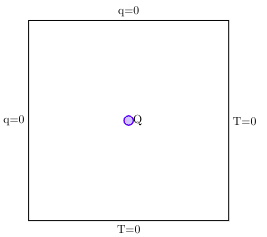

con: 

$$Q=10$$
$$\alpha =0.001$$
## Problema variacional

Encontrar un  $T \ \in \ V$  tal que 
$$
        \int \frac{\partial T}{\partial t}d\Omega +\int \alpha \nabla v \nabla T d\Omega  - \int_{\partial \Omega} \alpha q \cdot n ds - \int Qvd\Omega = 0
$$

In [22]:
# Importaciones necesarias
from __future__ import print_function
from fenics import *  # Importa FEniCS, una biblioteca popular para elementos finitos
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
import math
import scipy
import time
import scipy.sparse as sps
import scipy.sparse.linalg as spsl

from mshr import *
start = time.time()

parameters['linear_algebra_backend'] = 'Eigen'
# def tran2SparseMatrix(A):
#     row, col, val = as_backend_type(A).data()
#     return sps.csr_matrix((val, col, row))
# mempool = cupy.get_default_memory_pool()

# with cupy.cuda.Device(0):
#     mempool.set_limit(size=4*1024**3)
    
np.set_printoptions(formatter={'float': '{: 0.2E}'.format})
# Parámetros de simulación
T = math.pi/2            # Tiempo final
num_steps = 2000# Número de pasos de tiempo
dt = T / num_steps # Tamaño del paso de tiempo
alpha = 1e-1
Q=1000
q=Constant((10,0))
# Creación de la malla y definición del espacio de funciones
nx = ny = 21# Número de divisiones en x e y
#R=Rectangle(Point(-0.5,-0.5),Point(0.5,0.5))
#mesh=generate_mesh(R,64)
mesh = RectangleMesh(Point(0,0),Point(1,1),nx,ny)  # Crea una malla cuadrada unitaria
V = FunctionSpace(mesh, 'CG', 1) # Define el espacio de funciones con elementos lineales
V_vec = VectorFunctionSpace(mesh, 'CG',2)
# definición de fronteras
class Dirichlet_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return (near(x[1], 0) or near(x[0], 1)) and on_boundary


class Neumann_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return (near(x[1], 1) or near(x[0], 0)) and on_boundary
class source(SubDomain):
    def inside(self, x, on_boundary):
        return (near(x[1],0.5,0.05) and near(x[0], 0.5,0.05))  
subdomain = MeshFunction("size_t", mesh, mesh.topology().dim() )
subdomain.set_all(0)
source().mark(subdomain, 1)
boundary = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundary.set_all(0)


Dirichlet_boundary().mark(boundary, 2)  # mark left boundary with a 0
Neumann_boundary().mark(boundary, 1)  # mark right boundary with a 1

# Definición de la condición inicial
u_o =Expression(('1'),degree=2)



# Definición del problema variacional
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V)   # Función de test
n=FacetNormal(mesh)
ds = Measure('ds', domain=mesh, subdomain_data=boundary)
dx = Measure('dx', domain=mesh, subdomain_data=subdomain)


# Definición del valor inicial
u_n = interpolate(u_o, V)  # Interpola u_D en el espacio de funciones V


bc1 =DirichletBC(V,Constant(0),boundary,2)
#bc1 =DirichletBC(V,Constant(10.0),boundary,1)
bcs=[bc1]

fem =alpha*dot(grad(u), grad(v))*dx -dot(q,n)*v*ds(2) -v*Q*dx(1)  # Formulación débil
C_fem=u*v*dx


#ensamble vector de cargas
K_fem=lhs(fem)
f=rhs(fem)
Q_v=assemble(f)
bc1.apply(Q_v) #penalización
#ensamble matriz capacitiva 
C=assemble(C_fem)
bc1.apply(C) #penalización
#ensamble matriz de rigidez
K=assemble(K_fem)
bc1.apply(K) #penalización






In [23]:


# algoritmo de arnoldi 
def arnoldi_iteration_3(A, b, n):
    m = A.shape[0]

    h = np.zeros((n + 1, n))
    Q = np.zeros((m, n + 1))

    q = b / np.linalg.norm(b)
    Q[:, 0] = q

    for k in range(n):
        v = A.dot(q)
        for j in range(k + 1):
            h[j, k] = np.dot(Q[:, j].conj(), v)  # <-- Q needs conjugation!
            v = v - h[j, k] * Q[:, j]

        h[k + 1, k] = np.linalg.norm(v)
        eps = 1e-12
        if h[k + 1, k] > eps:
            q = v / h[k + 1, k]
            Q[:, k + 1] = q
        else:
            return Q[:,0:n], h[0:n, 0:n]
    return Q[:,0:n], h[0:n, 0:n]

# proceso 
vtkfile_u = XDMFFile("results_no_homogeneo/u_exp.xdmf")
vtkfile_u.parameters["flush_output"] = True
vtkfile_u.parameters["rewrite_function_mesh"] = False

t= 0
u_=Function(V)

#metodo sparse
K_=scipy.sparse.csr_matrix(K.array()) 
# plt.spy(s)
# plt.colorbar()
# plt.show()
N_degree=C.array().shape[0]
C=scipy.sparse.csc_matrix(C.array())
I_n=scipy.sparse.csc_matrix(scipy.sparse.identity(N_degree))
Q_v=Q_v.get_local()

start=time.time()
C_1=scipy.sparse.linalg.spsolve(C,I_n)

end = time.time()
#metodo coarse np
A=-C_1.dot(K_)
A=A.toarray()


#C_c = tran2SparseMatrix(C)
#C_c = cupyx.scipy.sparse.csr_matrix(C_c)
#bc.apply(C)


#I_np=np.identity(N_degree)
#I_cupy=cupyx.scipy.sparse.identity(N_degree)
# A1 = assemble(L)
# [bc.apply(A1) for bc in bcs]


# b1 = assemble(R)
# [bc.apply(b1) for bc in bcs]
# b1= b1[:]
# b1 = cupy.array(b1)
# X_w.vector()[:] = cupy.asnumpy(linalge.spsolve(A1, b1))
#C_1=np.linalg.solve(C.array(),I_np)
#C_1 = cupyx.scipy.sparse.linalg.spsolve(C_c, I_cupy)
    

print(f"time inv ={end-start}")
def Exp (A,tau=1):
    A=A.copy()
    
    A.resize(m+1,m+1)
    A[0,m]=1
    exp_m=scipy.linalg.expm(tau*A)
    return exp_m[:m,m]
def fi (A,tau=1):
    d=scipy.sparse.identity(m)
    
    A.resize(m+1,m+1)
    A[0,m]=1
    exp_m=scipy.linalg.expm(tau*A)
    return exp_m[:m,m]

u_i=np.dot(A,u_n.vector())+Q_v
m=20
v_hat=np.zeros(m)
v_hat[0]=1
#u_i=u_n.vector()
for n in range(num_steps):
    
    t += dt
    
    Beta=np.linalg.norm(u_i)
    V_m,H_m = arnoldi_iteration_3(A,u_i,m)

#     u_i=dt*Beta*np.dot(np.dot(V_m,fi(dt*H_m)),v_hat.T)
#     u_.vector()[:]=u_i
    if n == 0:
        u=dt*Beta*np.dot(V_m,Exp(H_m,dt)) + u_n.vector()
    else:
        u += dt*Beta*np.dot(V_m,Exp(H_m,dt))
    #u_i=np.dot(scipy.linalg.expm(dt*A),u_i)
    u_i=np.dot(A,u)+Q_v
    u_.vector()[:]=u
    
    print(Beta)
    
    if n%10==0:
        u_.rename("u_a", "u_a");vtkfile_u.write(u_, t)
    print(f'step:{n} of {num_steps} time= {t}')


time inv =0.3672494888305664
6.908275341270293
step:0 of 2000 time= 0.0007853981633974483
6.981777779395429
step:1 of 2000 time= 0.0015707963267948967
7.193996527912465
step:2 of 2000 time= 0.002356194490192345
7.652292428673907
step:3 of 2000 time= 0.0031415926535897933
8.219648524589331
step:4 of 2000 time= 0.003926990816987242
8.825949549121631
step:5 of 2000 time= 0.00471238898038469
9.430956513830097
step:6 of 2000 time= 0.005497787143782138
10.08375786047974
step:7 of 2000 time= 0.006283185307179586
10.754876170572098
step:8 of 2000 time= 0.007068583470577034
11.474608998981958
step:9 of 2000 time= 0.007853981633974482
12.154151995558879
step:10 of 2000 time= 0.00863937979737193
12.928885787058235
step:11 of 2000 time= 0.009424777960769378
13.77879344873418
step:12 of 2000 time= 0.010210176124166826
14.710400432054428
step:13 of 2000 time= 0.010995574287564274
15.689966699138587
step:14 of 2000 time= 0.011780972450961722
16.788460036880128
step:15 of 2000 time= 0.0125663706143591

1818.1459816274332
step:165 of 2000 time= 0.13037609512397696
1878.1050821229499
step:166 of 2000 time= 0.13116149328737442
1920.8946370798765
step:167 of 2000 time= 0.13194689145077187
1993.8607942403694
step:168 of 2000 time= 0.13273228961416933
1936.879454264647
step:169 of 2000 time= 0.13351768777756678
2038.9063094195255
step:170 of 2000 time= 0.13430308594096424
2076.3899613183426
step:171 of 2000 time= 0.1350884841043617
2145.4553146870353
step:172 of 2000 time= 0.13587388226775915
2077.577780055144
step:173 of 2000 time= 0.1366592804311566
2170.9975071867907
step:174 of 2000 time= 0.13744467859455406
2187.3010390655395
step:175 of 2000 time= 0.13823007675795151
2220.7355477987276
step:176 of 2000 time= 0.13901547492134897
2268.2964976134617
step:177 of 2000 time= 0.13980087308474642
2408.293369676732
step:178 of 2000 time= 0.14058627124814388
2370.241752410015
step:179 of 2000 time= 0.14137166941154133
2511.8888380169674
step:180 of 2000 time= 0.1421570675749388
2471.0651469187

32295.88628198576
step:311 of 2000 time= 0.2450442269800054
33622.08119053381
step:312 of 2000 time= 0.24582962514340284
33290.30569729287
step:313 of 2000 time= 0.2466150233068003
34728.95204017118
step:314 of 2000 time= 0.24740042147019775
35795.3203222624
step:315 of 2000 time= 0.2481858196335952
36490.34543910608
step:316 of 2000 time= 0.24897121779699266
36700.20864277959
step:317 of 2000 time= 0.24975661596039012
37614.00808081298
step:318 of 2000 time= 0.25054201412378757
38285.267183275086
step:319 of 2000 time= 0.251327412287185
39554.61352467734
step:320 of 2000 time= 0.2521128104505825
38376.94739677679
step:321 of 2000 time= 0.25289820861397994
40096.169167570486
step:322 of 2000 time= 0.2536836067773774
40594.85304014296
step:323 of 2000 time= 0.25446900494077485
42636.04123491372
step:324 of 2000 time= 0.2552544031041723
41888.135665158916
step:325 of 2000 time= 0.25603980126756976
44405.49084214904
step:326 of 2000 time= 0.2568251994309672
43536.39819003251
step:327 of 2

572045.6065942062
step:454 of 2000 time= 0.35735616434584144
569138.4455450902
step:455 of 2000 time= 0.3581415625092389
599767.4181059962
step:456 of 2000 time= 0.35892696067263635
588091.6237673458
step:457 of 2000 time= 0.3597123588360338
611262.9016927554
step:458 of 2000 time= 0.36049775699943126
616198.6470563079
step:459 of 2000 time= 0.3612831551628287
639981.6356986753
step:460 of 2000 time= 0.3620685533262262
638018.5057244285
step:461 of 2000 time= 0.3628539514896236
676319.6161875256
step:462 of 2000 time= 0.3636393496530211
667098.948920231
step:463 of 2000 time= 0.36442474781641854
709314.8896092323
step:464 of 2000 time= 0.365210145979816
699323.5072918765
step:465 of 2000 time= 0.36599554414321345
744778.7099888236
step:466 of 2000 time= 0.3667809423066109
720851.682915688
step:467 of 2000 time= 0.36756634047000836
759197.7893937018
step:468 of 2000 time= 0.3683517386334058
741750.5651974061
step:469 of 2000 time= 0.36913713679680327
783824.717034408
step:470 of 2000 ti

11360317.894804172
step:603 of 2000 time= 0.47438049069206223
11745483.817397786
step:604 of 2000 time= 0.4751658888554597
11890610.095085537
step:605 of 2000 time= 0.47595128701885714
12435964.140346495
step:606 of 2000 time= 0.4767366851822546
12394611.946127977
step:607 of 2000 time= 0.47752208334565205
12684230.199466411
step:608 of 2000 time= 0.4783074815090495
12795681.886033224
step:609 of 2000 time= 0.47909287967244696
13302830.936200617
step:610 of 2000 time= 0.4798782778358444
13139866.381046208
step:611 of 2000 time= 0.48066367599924187
13650881.477224207
step:612 of 2000 time= 0.4814490741626393
13907409.067126077
step:613 of 2000 time= 0.4822344723260368
14423681.009973157
step:614 of 2000 time= 0.48301987048943423
14467726.070413154
step:615 of 2000 time= 0.4838052686528317
15122535.513658067
step:616 of 2000 time= 0.48459066681622914
15198968.699195467
step:617 of 2000 time= 0.4853760649796266
15971018.458714757
step:618 of 2000 time= 0.48616146314302405
15808032.7206236

244297614.16238844
step:757 of 2000 time= 0.5953318078552635
265052488.70616516
step:758 of 2000 time= 0.5961172060186609
257131234.2533161
step:759 of 2000 time= 0.5969026041820583
271475646.2399094
step:760 of 2000 time= 0.5976880023454557
268022360.8676017
step:761 of 2000 time= 0.5984734005088531
283632964.282977
step:762 of 2000 time= 0.5992587986722505
276265894.1531573
step:763 of 2000 time= 0.6000441968356479
291428859.5908813
step:764 of 2000 time= 0.6008295949990453
299710071.5970751
step:765 of 2000 time= 0.6016149931624427
312563892.5114944
step:766 of 2000 time= 0.6024003913258401
305492562.60919136
step:767 of 2000 time= 0.6031857894892375
322541838.88007706
step:768 of 2000 time= 0.6039711876526349
319876834.22607833
step:769 of 2000 time= 0.6047565858160323
335394605.65695614
step:770 of 2000 time= 0.6055419839794297
327587202.9891367
step:771 of 2000 time= 0.6063273821428271
341764871.59080994
step:772 of 2000 time= 0.6071127803062245
348722973.1509752
step:773 of 2000

5466875230.390837
step:919 of 2000 time= 0.7225663103256422
5851255376.751704
step:920 of 2000 time= 0.7233517084890396
5751034030.397833
step:921 of 2000 time= 0.724137106652437
6008607669.380476
step:922 of 2000 time= 0.7249225048158344
5845900071.04713
step:923 of 2000 time= 0.7257079029792318
6211428357.832435
step:924 of 2000 time= 0.7264933011426292
6181103384.330595
step:925 of 2000 time= 0.7272786993060266
6472933331.841147
step:926 of 2000 time= 0.728064097469424
6482172211.010922
step:927 of 2000 time= 0.7288494956328214
6832642894.972057
step:928 of 2000 time= 0.7296348937962188
6626789931.621183
step:929 of 2000 time= 0.7304202919596162
6779836479.204935
step:930 of 2000 time= 0.7312056901230136
6996168593.574369
step:931 of 2000 time= 0.731991088286411
7242912598.971502
step:932 of 2000 time= 0.7327764864498084
7230728682.223754
step:933 of 2000 time= 0.7335618846132058
7622753778.400823
step:934 of 2000 time= 0.7343472827766032
7512817279.948853
step:935 of 2000 time= 0.7

138536645866.0851
step:1083 of 2000 time= 0.8513716091228157
143553343161.63342
step:1084 of 2000 time= 0.8521570072862131
143981483735.1724
step:1085 of 2000 time= 0.8529424054496105
152961555622.29965
step:1086 of 2000 time= 0.8537278036130079
148343959297.37698
step:1087 of 2000 time= 0.8545132017764053
159034553013.6989
step:1088 of 2000 time= 0.8552985999398027
159994974452.945
step:1089 of 2000 time= 0.8560839981032001
165994137007.4368
step:1090 of 2000 time= 0.8568693962665975
163494935225.202
step:1091 of 2000 time= 0.8576547944299949
167939967020.73895
step:1092 of 2000 time= 0.8584401925933923
171060633437.4776
step:1093 of 2000 time= 0.8592255907567897
184448961267.74396
step:1094 of 2000 time= 0.8600109889201871
180207684021.4989
step:1095 of 2000 time= 0.8607963870835845
188546116759.62573
step:1096 of 2000 time= 0.8615817852469819
192358297051.6555
step:1097 of 2000 time= 0.8623671834103793
198846320768.97665
step:1098 of 2000 time= 0.8631525815737767
196996673236.0368
s

2561362984099.762
step:1223 of 2000 time= 0.9613273519984517
2648900035326.943
step:1224 of 2000 time= 0.962112750161849
2589380008303.9893
step:1225 of 2000 time= 0.9628981483252465
2753899097587.393
step:1226 of 2000 time= 0.9636835464886438
2747035574202.5894
step:1227 of 2000 time= 0.9644689446520412
2812395186808.773
step:1228 of 2000 time= 0.9652543428154386
2808193979006.101
step:1229 of 2000 time= 0.966039740978836
2963469491421.7446
step:1230 of 2000 time= 0.9668251391422334
2904085375072.1875
step:1231 of 2000 time= 0.9676105373056308
3041527479755.979
step:1232 of 2000 time= 0.9683959354690282
3025393063654.0464
step:1233 of 2000 time= 0.9691813336324256
3110876531129.205
step:1234 of 2000 time= 0.969966731795823
3216035248986.995
step:1235 of 2000 time= 0.9707521299592204
3378601358682.521
step:1236 of 2000 time= 0.9715375281226178
3360489325586.286
step:1237 of 2000 time= 0.9723229262860152
3502521936337.61
step:1238 of 2000 time= 0.9731083244494126
3455736049747.105
step:

35998568631095.336
step:1360 of 2000 time= 1.0689269003838955
34982728290266.824
step:1361 of 2000 time= 1.0697122985472929
36850032913001.22
step:1362 of 2000 time= 1.0704976967106903
35333049947360.48
step:1363 of 2000 time= 1.0712830948740877
37358413105339.91
step:1364 of 2000 time= 1.072068493037485
37978683140670.92
step:1365 of 2000 time= 1.0728538912008825
39744324451016.97
step:1366 of 2000 time= 1.0736392893642799
38761430856254.21
step:1367 of 2000 time= 1.0744246875276773
40439477960467.93
step:1368 of 2000 time= 1.0752100856910747
40257067260423.25
step:1369 of 2000 time= 1.075995483854472
41567502713864.44
step:1370 of 2000 time= 1.0767808820178695
41054936469031.29
step:1371 of 2000 time= 1.0775662801812669
43729335750003.875
step:1372 of 2000 time= 1.0783516783446643
42234881526377.61
step:1373 of 2000 time= 1.0791370765080617
45098231637374.9
step:1374 of 2000 time= 1.079922474671459
43778838122249.055
step:1375 of 2000 time= 1.0807078728348565
46620040447632.81
step:1

543069698302922.44
step:1506 of 2000 time= 1.1835950322399158
532401385231381.94
step:1507 of 2000 time= 1.1843804304033132
557226910479450.3
step:1508 of 2000 time= 1.1851658285667106
549202096628525.9
step:1509 of 2000 time= 1.185951226730108
589406123037751.2
step:1510 of 2000 time= 1.1867366248935054
581304879478228.5
step:1511 of 2000 time= 1.1875220230569028
591878748482171.4
step:1512 of 2000 time= 1.1883074212203002
609981931527176.5
step:1513 of 2000 time= 1.1890928193836976
628372816751146.1
step:1514 of 2000 time= 1.189878217547095
619552039758408.9
step:1515 of 2000 time= 1.1906636157104924
644015478089330.9
step:1516 of 2000 time= 1.1914490138738898
646536669997700.1
step:1517 of 2000 time= 1.1922344120372872
668883148945888.2
step:1518 of 2000 time= 1.1930198102006846
679530797414097.2
step:1519 of 2000 time= 1.193805208364082
695935044709613.1
step:1520 of 2000 time= 1.1945906065274794
705612550248765.4
step:1521 of 2000 time= 1.1953760046908768
732116504167077.6
step:15

7394866113605934.0
step:1641 of 2000 time= 1.2896237842985647
7992212800657199.0
step:1642 of 2000 time= 1.2904091824619621
7809619367471566.0
step:1643 of 2000 time= 1.2911945806253595
8170344673438117.0
step:1644 of 2000 time= 1.291979978788757
8132949044538930.0
step:1645 of 2000 time= 1.2927653769521543
8602028465823811.0
step:1646 of 2000 time= 1.2935507751155517
8528196644365291.0
step:1647 of 2000 time= 1.2943361732789491
9173522680689856.0
step:1648 of 2000 time= 1.2951215714423465
8889015057574381.0
step:1649 of 2000 time= 1.295906969605744
9359862528318674.0
step:1650 of 2000 time= 1.2966923677691413
9434747185737966.0
step:1651 of 2000 time= 1.2974777659325387
9997405166846668.0
step:1652 of 2000 time= 1.2982631640959361
9654911232628816.0
step:1653 of 2000 time= 1.2990485622593335
1.0197141613971874e+16
step:1654 of 2000 time= 1.299833960422731
1.0075836575724886e+16
step:1655 of 2000 time= 1.3006193585861283
1.0551425785824086e+16
step:1656 of 2000 time= 1.3014047567495257

1.2534587999835083e+17
step:1781 of 2000 time= 1.3995795271742006
1.3015446144756182e+17
step:1782 of 2000 time= 1.400364925337598
1.339336024682901e+17
step:1783 of 2000 time= 1.4011503235009954
1.3987263416996501e+17
step:1784 of 2000 time= 1.4019357216643928
1.3801003131505678e+17
step:1785 of 2000 time= 1.4027211198277902
1.456199550838005e+17
step:1786 of 2000 time= 1.4035065179911876
1.496157049234869e+17
step:1787 of 2000 time= 1.404291916154585
1.5394097359155626e+17
step:1788 of 2000 time= 1.4050773143179824
1.4923347163422275e+17
step:1789 of 2000 time= 1.4058627124813798
1.6085161430559136e+17
step:1790 of 2000 time= 1.4066481106447772
1.580989835788429e+17
step:1791 of 2000 time= 1.4074335088081746
1.6730061999690858e+17
step:1792 of 2000 time= 1.408218906971572
1.6691382056409046e+17
step:1793 of 2000 time= 1.4090043051349694
1.7557874254517322e+17
step:1794 of 2000 time= 1.4097897032983668
1.710709152081345e+17
step:1795 of 2000 time= 1.4105751014617642
1.8250756521458534

2.5031092901666156e+18
step:1926 of 2000 time= 1.5134622608668236
2.3930030852255923e+18
step:1927 of 2000 time= 1.514247659030221
2.515739260033231e+18
step:1928 of 2000 time= 1.5150330571936184
2.5092790564406257e+18
step:1929 of 2000 time= 1.5158184553570158
2.655601333851329e+18
step:1930 of 2000 time= 1.5166038535204132
2.65706303123498e+18
step:1931 of 2000 time= 1.5173892516838106
2.829223696615557e+18
step:1932 of 2000 time= 1.518174649847208
2.78593749296393e+18
step:1933 of 2000 time= 1.5189600480106054
2.952023900863393e+18
step:1934 of 2000 time= 1.5197454461740028
2.890436091821402e+18
step:1935 of 2000 time= 1.5205308443374002
3.0275430572866616e+18
step:1936 of 2000 time= 1.5213162425007976
3.0279648077666693e+18
step:1937 of 2000 time= 1.522101640664195
3.195756874165859e+18
step:1938 of 2000 time= 1.5228870388275924
3.1696411465721626e+18
step:1939 of 2000 time= 1.5236724369909898
3.344289354129882e+18
step:1940 of 2000 time= 1.5244578351543872
3.3837933388270797e+18
s

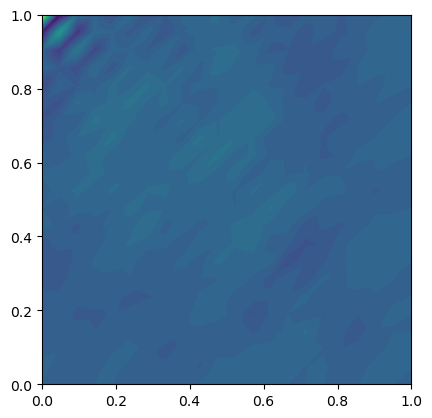

In [24]:
plot(u_)

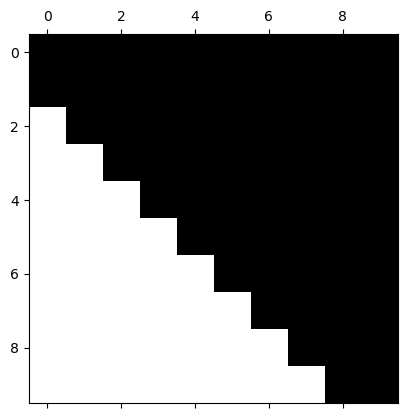

In [3]:

plt.spy(H_m)

In [2]:
vtkfile_u = XDMFFile("results/u_analitical.xdmf")
vtkfile_u.parameters["flush_output"] = True
vtkfile_u.parameters["rewrite_function_mesh"] = False

t=0
for n in range(num_steps):
    t += dt
    u_analytical.t=t
    u_ana = project(u_analytical,V)
    u_ana.rename("u_a", "u_a");vtkfile_u.write(u_ana, t)
    Beta=np.linalg.norm(u_ana.vector().get_local())
    print(Beta)

10.085024586935628
10.081069642749458
10.07711934783074
10.073173693077466
10.069232669412555
10.065296267783763
10.061364479163602
10.057437294549255
10.053514704962469
10.049596701449492
10.045683275080988
10.041774416951924
10.037870118181518
10.033970369913133
10.0300751633142
10.026184489576133
10.022298339914247
10.018416705567672
10.014539577799269
10.010666947895558
10.006798807166616
10.002935146946013
9.999075958590723
9.99522123348104
9.991370963020511
9.98752513863583
9.98368375177679
9.979846793916172
9.976014256549687
9.972186131195894
9.9683624093961
9.964543082714322
9.96072814273716
9.956917581073764
9.953111389355735
9.949309559237035
9.945512082393936
9.941718950524933
9.937930155350662
9.934145688613834
9.930365542079148
9.926589707533228
9.922818176784538
9.919050941663317
9.915287994021492
9.911529325732621
9.9077749286918
9.904024794815603
9.900278916042009
9.89653728433032
9.892799891661094
9.889066730036074
9.885337791478115
9.881613068031115
9.877892551759931


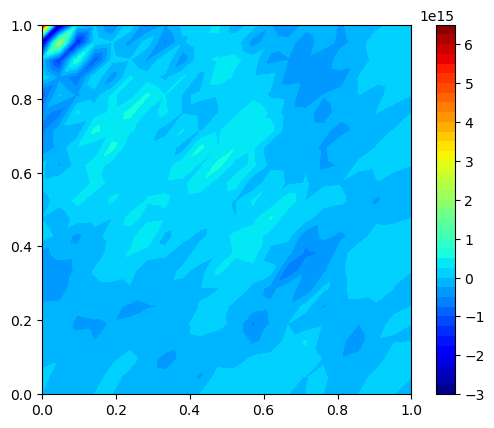

In [25]:

p=plot(u_)
p.set_cmap ('jet')
plt.colorbar(p)
plt.show()

In [44]:
from __future__ import print_function
from fenics import *  # Importa FEniCS, una biblioteca popular para elementos finitos
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
import math
import time


from mshr import *
start = time.time()

parameters['linear_algebra_backend'] = 'Eigen'
# def tran2SparseMatrix(A):
#     row, col, val = as_backend_type(A).data()
#     return sps.csr_matrix((val, col, row))
# mempool = cupy.get_default_memory_pool()

# with cupy.cuda.Device(0):
#     mempool.set_limit(size=4*1024**3)
    
np.set_printoptions(formatter={'float': '{: 0.2E}'.format})
# Parámetros de simulación
T = math.pi/2            # Tiempo final
num_steps = 2000# Número de pasos de tiempo
dt = T / num_steps # Tamaño del paso de tiempo
alpha = 1e-1
Q=1000
q=Constant((10,0))
# Creación de la malla y definición del espacio de funciones
nx = ny = 100# Número de divisiones en x e y
#R=Rectangle(Point(-0.5,-0.5),Point(0.5,0.5))
#mesh=generate_mesh(R,64)
mesh = RectangleMesh(Point(0,0),Point(1,1),nx,ny)  # Crea una malla cuadrada unitaria
V = FunctionSpace(mesh, 'CG', 1) # Define el espacio de funciones con elementos lineales
V_vec = VectorFunctionSpace(mesh, 'CG',2)
# definición de fronteras
class Dirichlet_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return (near(x[1], 0) or near(x[0], 1)) and on_boundary


class Neumann_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return (near(x[1], 1) or near(x[0], 0)) and on_boundary
class source(SubDomain):
    def inside(self, x, on_boundary):
        return (near(x[1],0.5,0.05) and near(x[0], 0.5,0.05))  
subdomain = MeshFunction("size_t", mesh, mesh.topology().dim() )
subdomain.set_all(0)
source().mark(subdomain, 1)
boundary = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundary.set_all(0)


Dirichlet_boundary().mark(boundary, 2)  # mark left boundary with a 0
Neumann_boundary().mark(boundary, 1)  # mark right boundary with a 1

# Definición de la condición inicial
u_o =Expression(('1'),degree=2)



# Definición del problema variacional
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V)   # Función de test
n=FacetNormal(mesh)
ds = Measure('ds', domain=mesh, subdomain_data=boundary)
dx = Measure('dx', domain=mesh, subdomain_data=subdomain)




# Definición del valor inicial
u_n = interpolate(u_o, V)  # Interpola u_D en el espacio de funciones V
u_nn = interpolate(u_o, V) 
u_nnn = interpolate(u_o, V) 


# Formulación del problema variacional
#pconst=[3./2,-2,1./2,0.0] #bdf2
#pconst = [0.48*11/6+0.52*3/2,0.48*-3+0.52*-2,0.48*3/2+0.52*1/2,0.48*-1/3] #bdf2 op
#pconst= [11/6,-3,3/2,-1/3] #bdf 3
pconst=[1,-1,0,0] #bdf1

du=pconst[0]*u
du_n=pconst[1]*u_n
du_nn=pconst[2]*u_nn
du_nnn=pconst[3]*u_nnn
du_t= du+du_n +du_nn +du_nnn
t= 0

vtkfile_ubdf = XDMFFile("results_no_homogeneo/u_BDF.xdmf")
vtkfile_ubdf.parameters["flush_output"] = True
vtkfile_ubdf.parameters["rewrite_function_mesh"] = False
bc1 =DirichletBC(V,Constant(0),boundary,2)
#bc1 =DirichletBC(V,Constant(10.0),boundary,1)
bcs=[bc1]

F = du_t*v*dx+dt*alpha*dot(grad(u), grad(v))*dx -dt*dot(q,n)*v*ds(1) -dt*v*Q*dx(1)# Formulación débil
a, L = lhs(F), rhs(F)  # Separa la parte izquierda y derecha de la ecuación



In [45]:

for n in range(num_steps):

    if n%100==0:
        u_.rename("u_a", "u_a");vtkfile_ubdf.write(u_, t)
    # Actualizar el tiempo actual
    t += dt
    # Resolver la solución
    A=assemble(a)
    b=assemble(L)
    [bc.apply(A) for bc in bcs]
    [bc.apply(b) for bc in bcs]
    solve(A, u_.vector(),b)
    # Graficar la solución
    print(f'step:{n} of {num_steps}')
    print(np.array(u_.vector()).max())
    # Calcular el error
#     u_e = interpolate(u_D, V)  # Interpolar la solución exacta
#     error = np.abs(np.array(u_e.vector()) - np.array(u.vector())).max()  # Error máximo
#     print('t = %.2f: error = %.3g' % (t, error))

    # Actualizar la solución anterior
    u_nnn.assign(u_nn)
    u_nn.assign(u_n)
    u_n.assign(u_)
    
    


step:0 of 2000
1.7815300257659086
step:1 of 2000
2.549992857568735
step:2 of 2000
3.294686771561109
step:3 of 2000
4.007472327001932
step:4 of 2000
4.684034552853927
step:5 of 2000
5.323211527919451
step:6 of 2000
5.925857628546508
step:7 of 2000
6.493913794577146
step:8 of 2000
7.0298001990023495
step:9 of 2000
7.536062374472122
step:10 of 2000
8.015181583931776
step:11 of 2000
8.469482651293411
step:12 of 2000
8.901096678228365
step:13 of 2000
9.311953348042442
step:14 of 2000
9.703788330195925
step:15 of 2000
10.078157694509756
step:16 of 2000
10.436454923728434
step:17 of 2000
10.77992819748002
step:18 of 2000
11.109696787517885
step:19 of 2000
11.426766048498157
step:20 of 2000
11.73204083704033
step:21 of 2000
12.026337373600168
step:22 of 2000
12.310393650242583
step:23 of 2000
12.5848785245292
step:24 of 2000
12.850399649165404
step:25 of 2000
13.107510382212663
step:26 of 2000
13.356715811093784
step:27 of 2000
13.598478009455258
step:28 of 2000
13.833220631424771
step:29 of 2

step:234 of 2000
29.270104769594937
step:235 of 2000
29.301786459402894
step:236 of 2000
29.333315648966504
step:237 of 2000
29.364693443962537
step:238 of 2000
29.395920937247034
step:239 of 2000
29.426999209071447
step:240 of 2000
29.457929327293883
step:241 of 2000
29.48871234758597
step:242 of 2000
29.519349313635217
step:243 of 2000
29.54984125734309
step:244 of 2000
29.580189199018985
step:245 of 2000
29.610394147569945
step:246 of 2000
29.640457100686504
step:247 of 2000
29.670379045024653
step:248 of 2000
29.70016095638395
step:249 of 2000
29.729803799881896
step:250 of 2000
29.759308530124848
step:251 of 2000
29.78867609137523
step:252 of 2000
29.817907417715457
step:253 of 2000
29.847003433208407
step:254 of 2000
29.875965052054674
step:255 of 2000
29.90479317874657
step:256 of 2000
29.93348870821913
step:257 of 2000
29.962052525997898
step:258 of 2000
29.990485508343927
step:259 of 2000
30.018788522395756
step:260 of 2000
30.046962426308575
step:261 of 2000
30.07500806939069

step:466 of 2000
33.9381082574161
step:467 of 2000
33.950476281271385
step:468 of 2000
33.96279977426414
step:469 of 2000
33.97507892388599
step:470 of 2000
33.98731391659749
step:471 of 2000
33.999504937835624
step:472 of 2000
34.011652172021115
step:473 of 2000
34.023755802565795
step:474 of 2000
34.035816011879696
step:475 of 2000
34.047832981378264
step:476 of 2000
34.0598068914895
step:477 of 2000
34.07173792166086
step:478 of 2000
34.083626250366294
step:479 of 2000
34.09547205511306
step:480 of 2000
34.107275512448695
step:481 of 2000
34.11903679796756
step:482 of 2000
34.130756086317724
step:483 of 2000
34.142433551207475
step:484 of 2000
34.15406936541201
step:485 of 2000
34.165663700779874
step:486 of 2000
34.177216728239394
step:487 of 2000
34.18872861780516
step:488 of 2000
34.20019953858433
step:489 of 2000
34.21162965878292
step:490 of 2000
34.223019145711994
step:491 of 2000
34.23436816579389
step:492 of 2000
34.24567688456831
step:493 of 2000
34.256945466698376
step:494

step:699 of 2000
35.913260397067056
step:700 of 2000
35.91879886823129
step:701 of 2000
35.92431867463601
step:702 of 2000
35.92981987864643
step:703 of 2000
35.9353025423709
step:704 of 2000
35.94076672766232
step:705 of 2000
35.946212496119394
step:706 of 2000
35.95163990908786
step:707 of 2000
35.957049027661874
step:708 of 2000
35.96243991268517
step:709 of 2000
35.96781262475244
step:710 of 2000
35.97316722421049
step:711 of 2000
35.97850377115959
step:712 of 2000
35.983822325454625
step:713 of 2000
35.98912294670639
step:714 of 2000
35.99440569428278
step:715 of 2000
35.999670627310074
step:716 of 2000
36.00491780467406
step:717 of 2000
36.01014728502131
step:718 of 2000
36.015359126760366
step:719 of 2000
36.0205533880629
step:720 of 2000
36.02573012686493
step:721 of 2000
36.03088940086796
step:722 of 2000
36.03603126754024
step:723 of 2000
36.04115578411781
step:724 of 2000
36.04626300760575
step:725 of 2000
36.05135299477925
step:726 of 2000
36.05642580218484
step:727 of 2000

36.806584967780054
step:934 of 2000
36.809038574710904
step:935 of 2000
36.8114831348738
step:936 of 2000
36.81391867435612
step:937 of 2000
36.81634521915741
step:938 of 2000
36.818762795189706
step:939 of 2000
36.82117142827793
step:940 of 2000
36.82357114416021
step:941 of 2000
36.82596196848828
step:942 of 2000
36.82834392682779
step:943 of 2000
36.83071704465869
step:944 of 2000
36.83308134737562
step:945 of 2000
36.835436860288155
step:946 of 2000
36.83778360862127
step:947 of 2000
36.84012161751562
step:948 of 2000
36.84245091202789
step:949 of 2000
36.84477151713115
step:950 of 2000
36.84708345771523
step:951 of 2000
36.84938675858701
step:952 of 2000
36.85168144447074
step:953 of 2000
36.85396754000849
step:954 of 2000
36.85624506976036
step:955 of 2000
36.85851405820487
step:956 of 2000
36.860774529739295
step:957 of 2000
36.86302650868
step:958 of 2000
36.86527001926274
step:959 of 2000
36.867505085643
step:960 of 2000
36.86973173189636
step:961 of 2000
36.87194998201873
ste

step:1162 of 2000
37.17555254566278
step:1163 of 2000
37.17647506234069
step:1164 of 2000
37.177392771515066
step:1165 of 2000
37.17830568597737
step:1166 of 2000
37.1792138184823
step:1167 of 2000
37.18011718174785
step:1168 of 2000
37.18101578845545
step:1169 of 2000
37.18190965125015
step:1170 of 2000
37.18279878274069
step:1171 of 2000
37.18368319549958
step:1172 of 2000
37.18456290206337
step:1173 of 2000
37.185437914932635
step:1174 of 2000
37.18630824657216
step:1175 of 2000
37.187173909411094
step:1176 of 2000
37.18803491584297
step:1177 of 2000
37.188891278225945
step:1178 of 2000
37.189743008882836
step:1179 of 2000
37.19059012010131
step:1180 of 2000
37.19143262413396
step:1181 of 2000
37.192270533198425
step:1182 of 2000
37.19310385947754
step:1183 of 2000
37.193932615119394
step:1184 of 2000
37.19475681223758
step:1185 of 2000
37.19557646291112
step:1186 of 2000
37.19639157918477
step:1187 of 2000
37.19720217306903
step:1188 of 2000
37.1980082565403
step:1189 of 2000
37.19

step:1390 of 2000
37.28292201341623
step:1391 of 2000
37.28301948278101
step:1392 of 2000
37.2831143098169
step:1393 of 2000
37.283206501417034
step:1394 of 2000
37.28329606445679
step:1395 of 2000
37.28338300579401
step:1396 of 2000
37.28346733226894
step:1397 of 2000
37.283549050704316
step:1398 of 2000
37.28362816790545
step:1399 of 2000
37.28370469066023
step:1400 of 2000
37.28377862573919
step:1401 of 2000
37.28384997989556
step:1402 of 2000
37.28391875986533
step:1403 of 2000
37.28398497236729
step:1404 of 2000
37.284048624103086
step:1405 of 2000
37.28410972175729
step:1406 of 2000
37.28416827199739
step:1407 of 2000
37.28422428147388
step:1408 of 2000
37.28427775682032
step:1409 of 2000
37.2843287046534
step:1410 of 2000
37.28437713157294
step:1411 of 2000
37.284423044161954
step:1412 of 2000
37.28446644898673
step:1413 of 2000
37.28450735259684
step:1414 of 2000
37.28454576152522
step:1415 of 2000
37.28458168228821
step:1416 of 2000
37.28461512138561
step:1417 of 2000
37.28464

step:1617 of 2000
37.24885014829805
step:1618 of 2000
37.24849551843322
step:1619 of 2000
37.248139441876894
step:1620 of 2000
37.24778192256784
step:1621 of 2000
37.2474229644353
step:1622 of 2000
37.24706257139931
step:1623 of 2000
37.24670074737052
step:1624 of 2000
37.24633749625026
step:1625 of 2000
37.2459728219306
step:1626 of 2000
37.24560672829438
step:1627 of 2000
37.245239219215186
step:1628 of 2000
37.244870298557395
step:1629 of 2000
37.244499970176214
step:1630 of 2000
37.24412823791772
step:1631 of 2000
37.243755105618796
step:1632 of 2000
37.243380577107295
step:1633 of 2000
37.243004656201926
step:1634 of 2000
37.24262734671233
step:1635 of 2000
37.242248652439166
step:1636 of 2000
37.24186857717406
step:1637 of 2000
37.24148712469959
step:1638 of 2000
37.24110429878943
step:1639 of 2000
37.240720103208325
step:1640 of 2000
37.24033454171202
step:1641 of 2000
37.23994761804747
step:1642 of 2000
37.239559335952634
step:1643 of 2000
37.239169699156726
step:1644 of 2000
3

step:1845 of 2000
37.13731566840592
step:1846 of 2000
37.136717207268624
step:1847 of 2000
37.136117995585494
step:1848 of 2000
37.13551803567071
step:1849 of 2000
37.13491732983317
step:1850 of 2000
37.13431588037649
step:1851 of 2000
37.13371368959902
step:1852 of 2000
37.13311075979381
step:1853 of 2000
37.13250709324867
step:1854 of 2000
37.13190269224618
step:1855 of 2000
37.131297559063654
step:1856 of 2000
37.130691695973226
step:1857 of 2000
37.13008510524182
step:1858 of 2000
37.12947778913114
step:1859 of 2000
37.128869749897746
step:1860 of 2000
37.128260989793
step:1861 of 2000
37.12765151106313
step:1862 of 2000
37.12704131594921
step:1863 of 2000
37.12643040668716
step:1864 of 2000
37.125818785507846
step:1865 of 2000
37.12520645463696
step:1866 of 2000
37.12459341629513
step:1867 of 2000
37.123979672697885
step:1868 of 2000
37.123365226055704
step:1869 of 2000
37.12275007857401
step:1870 of 2000
37.122134232453135
step:1871 of 2000
37.12151768988844
step:1872 of 2000
37.

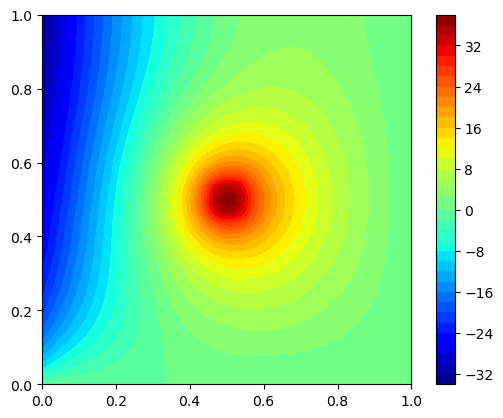

In [46]:
p=plot(u_)
p.set_cmap ('jet')
plt.colorbar(p)
plt.show()

In [45]:
u_(0,0.5)

10.0